In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
from script import eval

In [2]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    out_lb = nn_layer_out_bounds[-1][0]
    out_ub = nn_layer_out_bounds[-1][1]
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    difference_lb.pop(label)
    difference_ub.pop(label)
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)

    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)


In [3]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [4]:
def get_output_vars_snv_milp(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("affine_var{}[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [5]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [6]:
def optimize_model(model, output_vars):
    start = time.time()
    model.update()
    model.optimize()
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

In [7]:
transform = Compose([ToTensor(),  Normalize(0.5, 0.5)])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

"""nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device('cpu')), strict=False)"""

"""nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc_6x256.pth", map_location=torch.device('cpu')), strict=False)"""

nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device('cpu')), strict=False)


parameter_list = list(nn.parameters())

output_size = 10
number_layer = (len(parameter_list) - 2) // 2

=========================================== 18 ===========================================


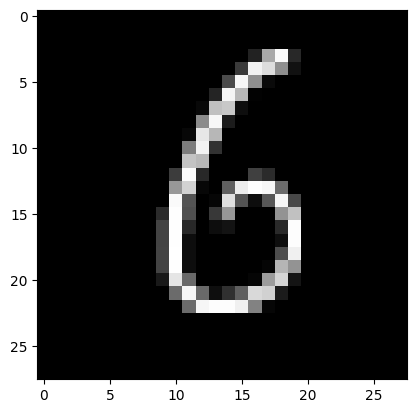

6
tensor([-172.0694, -176.8615, -162.1011, -177.4311, -169.6750, -166.8041,
        -183.9420, -177.7420, -171.6015, -172.2942], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([161.3770, 166.0988, 169.6522, 170.3519, 179.9586, 193.6648, 167.5022,
        195.0780, 178.0849, 175.9675], dtype=torch.float64,
       grad_fn=<AddBackward0>)
nn classifies image correct as 6


In [8]:
image_index = 18
eps = 0.009
use_milp = False


print("=========================================== {} ===========================================".format(image_index))
image, label = training_data.__getitem__(image_index)
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(label)

input_flattened = torch.flatten(torch_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[-1][0])
print(simple_bounds_affine_out[-1][1])

if torch.argmax(nn(torch_image)).item() == label:
    print("nn classifies image correct as {}".format(label))
else:
    print("nn classifies image wrong")


In [9]:
t = time.time()
snv_verifier = SingleNeuronVerifier(nn, torch_image, eps, print_log=False, print_new_bounds=True, optimize_bounds=True)
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()
snv_out_vars = get_output_vars_snv_milp(snv_model, output_size, number_layer * 2)
add_output_constraints(snv_model, simple_bounds_layer_out, label, snv_out_vars)
print("start with optimization")
optimize_model(snv_model, snv_out_vars)
print("verification time: {}".format(time.time() - t))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12
================ layer 0 ===============
================ layer 1 ===============
        0, lower: new 1.1343413368606192, old 0.49947197175706837
        0, upper: new 1.3302881769981658, old 1.9645537197832599
        1, lower: new 0.23386656164067576, old -0.37432643127703114
        1, upper: new 0.4152641910734309, old 1.0356475700046799
        2, lower: new 0.5526623219172757, old -0.03427886606290853


KeyboardInterrupt: 

In [10]:
if use_milp:
    milp_verifier = MILPVerifier(nn, torch_image, eps, print_log=False)
    milp_verifier.generate_constraints_for_net()
    milp_model = milp_verifier.model
    milp_model.update()
    milp_out_vars = get_output_vars_snv_milp(milp_model, output_size, number_layer * 2)
    add_output_constraints(milp_model, simple_bounds_layer_out, label, milp_out_vars)
    print("start with optimization")
    optimize_model(milp_model, milp_out_vars)

In [11]:
group_size = 5
icnn_factory = ICNNFactory("logical", [5, 1], always_use_logical_layer=False)
#icnn_factory = ICNNFactory("standard", [5, 1])
# icnn_factory = ICNNFactory("approx_max", [5, 1], maximum_function="SMU", function_parameter=0.3)

dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=200,
                                 icnn_batch_size=1000, sample_count=300, sample_new=False, use_over_approximation=True, break_after=None,
                                 sample_over_input_space=False, sample_over_output_space=True, use_icnn_bounds=True,
                                 use_fixed_neurons=True, sampling_method="per_group_sampling",
                                 force_inclusion_steps=0, preemptive_stop=True, even_gradient_training=False,
                                 keep_ambient_space=True, data_grad_descent_steps=0, opt_steps_gd=200,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 grouping_method="random", group_num_multiplier=5, store_samples=False, print_optimization_steps=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included")


approximation of layer: 0
    number of fixed neurons for current layer: 213
    layer progress, group 1 of 45 
        time for sampling for one group: 0.0
        time for training: 0.4683091640472412
        actual verification time 0.060724735260009766
        time for verification: 0.14167475700378418
    layer progress, group 2 of 45 
        time for sampling for one group: 0.002025604248046875
        time for training: 0.5288364887237549
        actual verification time 0.031267404556274414
        time for verification: 0.08465933799743652
    layer progress, group 3 of 45 
        time for sampling for one group: 0.0
        time for training: 2.363926410675049
        actual verification time 0.0423431396484375
        time for verification: 0.10071110725402832
    layer progress, group 4 of 45 
        time for sampling for one group: 0.0
        time for training: 0.5139498710632324
        actual verification time 0.040285348892211914
        time for verification: 0.08

In [12]:
print(dhov_verifier.all_group_indices)

[[[20, 22, 24, 90, 178], [22, 27, 84, 213, 252], [74, 75, 88, 90, 213], [20, 46, 84, 85, 237], [22, 46, 130, 180, 252], [33, 100, 130, 136, 243], [42, 96, 133, 138, 216], [22, 46, 74, 85, 234], [50, 75, 88, 96, 144], [20, 85, 95, 138, 243], [38, 74, 97, 206, 243], [24, 65, 97, 112, 138], [65, 85, 112, 136, 216], [27, 84, 158, 178, 229], [9, 15, 24, 61, 202], [9, 15, 65, 158, 252], [38, 97, 144, 206, 234], [15, 33, 100, 178, 234], [46, 90, 229, 237, 252], [22, 31, 88, 112, 243], [42, 138, 158, 178, 237], [15, 61, 97, 178, 229], [15, 31, 75, 90, 178], [24, 90, 144, 213, 234], [75, 97, 130, 234, 252], [85, 88, 158, 178, 202], [95, 97, 136, 202, 252], [24, 130, 158, 213, 243], [15, 33, 158, 206, 213], [24, 42, 229, 243, 252], [50, 65, 158, 213, 252], [20, 27, 84, 136, 206], [75, 84, 138, 158, 234], [4, 38, 90, 234, 237], [20, 65, 180, 202, 234], [20, 74, 90, 138, 234], [20, 31, 46, 74, 202], [61, 75, 112, 178, 180], [27, 38, 206, 234, 237], [9, 74, 88, 95, 97], [22, 31, 61, 100, 144], [95,

In [13]:
print(dhov_verifier.bounds_affine_out[-1][0])
print(dhov_verifier.bounds_affine_out[-1][1])

tensor([-0.2577, -2.5059, -1.7737, -2.4913, -1.1465,  3.9390,  5.0412, -7.2995,
         1.4359, -2.5491], dtype=torch.float64, grad_fn=<CopySlices>)
tensor([ 0.9908, -1.2468, -0.3721, -0.9058,  0.2634,  5.4661,  6.7476, -6.2147,
         2.8109, -1.2628], dtype=torch.float64, grad_fn=<CopySlices>)


In [14]:
dhov_model = dhov_verifier.nn_encoding_model.copy()
dhov_model.update()
dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

In [15]:
add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars)

In [16]:
optimize_model(dhov_model, dhov_out_vars)

var 0: 0.18854497440587537
var 1: -1.8136582727878237
var 2: -1.4235527240651953
var 3: -1.1981813851416199
var 4: -0.7280351304556749
var 5: 5.267652878177337
var 6: 5.270698951753958
var 7: -6.809015014915084
var 8: 2.189192434064145
var 9: -1.570468411491162
property verified with max difference -0.003046073576620678


True

In [15]:
for layer_index, icnn_per_layer in enumerate(dhov_verifier.list_of_icnns):
    for group_index, current_icnn in enumerate(icnn_per_layer):
        current_group = torch.tensor(dhov_verifier.all_group_indices[layer_index][group_index], dtype=torch.int64)
        print("Current layer {}, current group {}".format(layer_index, current_group))
        if len(current_group) != 2:
            continue


        optimized_x = dhov_model.getVarByName("output_layer_[{}]_[{}]".format(layer_index, current_group[0])).getAttr("x")
        optimized_y = dhov_model.getVarByName("output_layer_[{}]_[{}]".format(layer_index, current_group[1])).getAttr("x")


        if layer_index != 4:
            snv_optimized_x = snv_model.getVarByName("relu_var{}[{}]".format(2*layer_index, current_group[0])).getAttr("x")
            snv_optimized_y = snv_model.getVarByName("relu_var{}[{}]".format(2*layer_index, current_group[1])).getAttr("x")
        else:
            snv_optimized_x = snv_model.getVarByName("last_affine_var[{}]".format(current_group[0])).getAttr("x")
            snv_optimized_y = snv_model.getVarByName("last_affine_var[{}]".format(current_group[1])).getAttr("x")

        is_snv_value_inside = current_icnn(torch.tensor([[snv_optimized_x, snv_optimized_y]], dtype=data_type)) <= 0

        if is_snv_value_inside or abs(optimized_x - snv_optimized_y) <= 1e-4 or abs(optimized_y - snv_optimized_y) <= 1e-4:
            continue

        group_inc_space = torch.index_select(dhov_verifier.list_of_included_samples[layer_index][group_index], 1, current_group)
        group_amb_space = torch.index_select(dhov_verifier.list_of_ambient_samples[layer_index][group_index], 1, current_group)
        min_x, max_x, min_y, max_y = multidhov.get_min_max_x_y(torch.cat([group_inc_space.detach(), group_amb_space.detach()]))
        plots = eval.Plots_for(0, current_icnn, group_inc_space.detach(), group_amb_space.detach(),
                          [min_x, max_x], [min_y, max_y])
        plt.style.use("default")
        plots.plt_mesh(show=False)
        plt.plot(optimized_x, optimized_y, "Dg")

        plt.plot(snv_optimized_x, snv_optimized_y, "+r")

        plt.show()



Current layer 0, current group tensor([ 4,  9, 15, 20, 22, 24, 27, 31, 33, 38, 42, 46, 50, 61, 65])
Current layer 0, current group tensor([ 74,  75,  84,  85,  88,  90,  95,  96,  97, 100, 112, 130, 133, 136,
        138])
Current layer 0, current group tensor([144, 158, 178, 180, 202, 206, 213, 216, 229, 234, 237, 243, 252])
Current layer 1, current group tensor([  5,  17,  19,  35,  59,  67,  68,  85,  86, 100, 102, 104, 117, 124,
        142])
Current layer 1, current group tensor([154, 164, 169, 175, 191, 193, 199, 220, 247])
Current layer 2, current group tensor([ 12,  14,  19,  22,  24,  50,  55,  56,  60,  77,  82,  83,  84, 107,
        118])
Current layer 2, current group tensor([133, 147, 163, 167, 173, 181, 186, 205, 243, 244, 248])
Current layer 3, current group tensor([ 10,  11,  14,  26,  40,  51,  52,  53,  55,  56,  72,  97,  99, 100,
        101])
Current layer 3, current group tensor([107, 109, 120, 128, 133, 144, 146, 162, 165, 176, 204, 207, 208])
